# Physics 201 Week 9: Markov Chain Monte Carlo in Python

Vinothan N. Manoharan

There are at least three options for doing MCMC in Python:

1. [emcee](http://dan.iel.fm/emcee/current/): emcee is a small but powerful MCMC sampler.  It does both Metropolis-Hastings sampling as well as another method called "affine-invariant ensemble sampling" that can efficiently deal with asymmetric posteriors.  There is a version of the affine-invariant sampler that uses parallel tempering.  The affine-invariant sampler requires continuous (non-integer) parameters. Using emcee is fairly straightforward, involving specifying a function for the log-posterior and passing it to the sampler. It might be more cumbersome to use with more complicated models, since there is no infrastructure for model specification.  It can be installed using `conda install -c conda-forge emcee`

2. [PyMC version 3](http://pymc-devs.github.io/pymc3/): PyMC3 includes a No U-Turn Sampler (NUTS), a variation on Hamiltonian Monte Carlo that is efficient at handling high-dimensional models and that requires very little tuning.  It also has a model specification language, and it can automatically calculate the likelihood function from the model, which makes it a powerful framework for doing inference.  You can install it using `conda install -c conda-forge pymc3`.  I'll cover it in a later notebook.

3. [PySTAN](https://pystan.readthedocs.org/en/latest/): PySTAN is a python interface to the statistical modeling language STAN.  You write your models in STAN and then run a sampler (and analyze your results) using the python interface.  PySTAN also includes NUTS.  You can install it using `conda install -c conda-forge pymc3`.

Another python package to consider is [pymultinest](http://johannesbuchner.github.io/PyMultiNest/), which implements nested sampling. 

## Getting started with emcee

In the following tutorial I'll show you how to use emcee, which is the simplest of the four options above to get running.

Sources:
- http://dan.iel.fm/emcee/current/user/line/
- http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
- http://astrobites.org/2012/02/20/code-you-can-use-the-mcmc-hammer/

In [1]:
# makes plots display inline in notebook interface:
%matplotlib inline 

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import emcee
import pandas as pd
# we'll make use of seaborn's features, so make sure you've 
# installed it using conda
import seaborn as sns

## Read in the data
The data are from Hogg, Bovy, and Lang Table 1:

In [3]:
dataHBL = pd.DataFrame({ 'x': [201, 244, 47, 287, 203, 58, 210, 202, 198, 158,
                               165, 201, 157, 131, 166, 160, 186, 125, 218, 146],
                         'y': [592, 401, 583, 402, 495, 173, 479, 504, 510, 416,
                               393, 442, 317, 311, 400, 337, 423, 334, 533, 344],
                         'sigma_y': [61, 25, 38, 15, 21, 15, 27, 14, 30, 16,
                                     14, 25, 52, 16, 34, 31, 42, 26, 16, 22],
                         'sigma_x': [9, 4, 11, 7, 5, 9, 4, 4, 11, 7,
                                     5, 5, 5, 6, 6, 5, 9, 8, 6, 5],
                         'rho_xy': [-0.84, 0.31, 0.64, -0.27, -0.33, 0.67, -0.02, -0.05, -0.84, -0.69,
                                    0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 0.90, 0.40, -0.78, -0.56]})

## Example problem
We'll redo the fit to a straight line, using MCMC instead of least squares.

### Step 1: define a function for the posterior probability density

We only need to define one function, but I'll first define the prior and the likelihood, to make things more clear.  Note that emcee expects to get the log of the posterior probability.  For the prior, I'll use a uniform (improper) prior on both $m$ and $b$.

In [4]:
def log_prior(theta):
    """
    returns log of prior probability distribution
    
    Parameters:
        theta: model parameters (specified as a tuple)
    """
    # unpack the model parameters
    m, b = theta
  
    # we don't have to explicitly normalize our prior
    return 0
    
def log_likelihood(theta, x, y, sigma_y):
    """
    returns log of likelihood
    
    Parameters:
        theta: model parameters (specified as a tuple)
        x: independent data (array of length N)
        y: measurements (array of length N)
        sigma_y: uncertainties on y (array of length N)
    """
    m, b = theta
    residual = (y - m*x - b)**2
    chi_square = np.sum(residual/(sigma_y**2))
    constant = np.sum(np.log(1/np.sqrt(2.0*np.pi*sigma_y**2)))
    return constant - 0.5*chi_square

def log_posterior(theta, x, y, sigma_y):
    """
    returns log of posterior probability distribution
    
    Parameters:
        theta: model parameters (specified as a tuple)
        x: independent data (array of length N)
        y: measurements (array of length N)
        sigma_y: uncertainties on y (array of length N)
    """
    m, b = theta
    return log_prior(theta) + log_likelihood(theta, x, y, sigma_y)

### Step 2: set up the walkers

In [5]:
# the model has 2 parameters; we'll use 50 walkers and 500 steps each
ndim = 2
nwalkers = 50
nsteps = 500

# set up the walkers in a "Gaussian ball" around the least-squares estimate
# see http://dan.iel.fm/emcee/current/user/line/
ls_result = [2.24, 34] # from HBL figure 1
starting_positions = [ls_result + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

### Step 3: let 'em go
We'll set up a sampler object and let our walkers roam. The EnsembleSampler class initializes a sampler that uses the affine-invariant ensemble sampling algorithm.

In [6]:
# trim the first few data points, as instructed
x = dataHBL['x'][4:]
y = dataHBL['y'][4:]
sigma_y = dataHBL['sigma_y'][4:]

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=(x, y, sigma_y))
# run the sampler. We use iPython's %time directive to tell us 
# how long it took (in a script, you would leave out "%time")
%time sampler.run_mcmc(starting_positions, nsteps)
print('Done')

Wall time: 23.7 s
Done


### Step 4: check burn-in time and trim samples
To check the "burn-in" time we plot traces of the samples of m and b from the first ten walkers

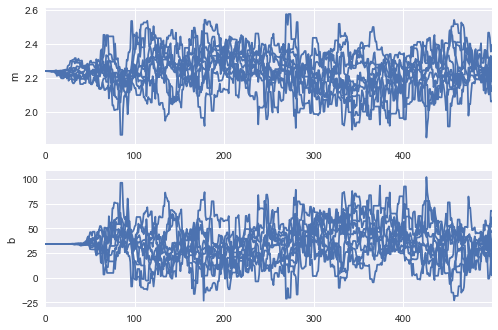

In [7]:
fig, (ax_m, ax_b) = plt.subplots(2)
ax_m.set(ylabel='m')
ax_b.set(ylabel='b')
for i in range(10):
    sns.tsplot(sampler.chain[i,:,0], ax=ax_m)
    sns.tsplot(sampler.chain[i,:,1], ax=ax_b)

It looks like the burn-in time is around 100 steps, so we'll remove all the samples before then.  It's not necessarily true that the walkers have equilibrated after 100 steps (there might be another mode of the posterior they haven't explored yet), so in general it's good to try different starting distributions of walkers and see if the burn-in time remains the same.

In [8]:
samples = sampler.chain[:,100:,:]
# reshape the samples into a 1D array where the colums are m and b
traces = samples.reshape(-1, ndim).T
# create a pandas DataFrame with labels.  This will come in handy 
# in a moment, when we start using seaborn to plot our results 
# (among other things, it saves us the trouble of typing in labels
# for our plots)
parameter_samples = pd.DataFrame({'m': traces[0], 'b': traces[1]})

## Step 5: plot
Now let's plot our results.  Here is where seaborn comes in handy.  It is made to deal with statistical samples.  Let's look at the joint distribution of m and b from the MCMC run.

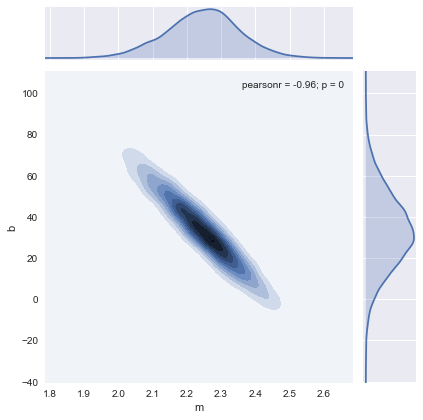

In [9]:
joint_kde = sns.jointplot(x='m', y='b', data=parameter_samples, kind='kde')

What I did above is to plot a kernel density estimate of the joint distribution (recall that a kernel density estimate allows you to approximate a discrete distribution as a continuous one).  Note the nice contour lines in the center, and compare the plot to Figure 4 (left) in HBL.  The joint distribution fully characterizes the covariance between the two parameters.

The plots at the top and right margins are the marginal distributions $p(m \mid D,I)$ and $p(b \mid D,I)$. It's very easy to get the marginal distributions from the MCMC samples -- you can simply bin all the samples of, say $m$, independent of the values of $b$.  Note that the plot even shows why they are called "marginal distributions"; they are called that because they appear in the margins of the joint distribution.

Since what we've done is just the MCMC version of a linear least-squares fit, we expect both $p(m \mid D,I)$ and $p(b \mid D,I)$ to be Gaussian, and indeed they are, to a good approximation.

We did all of that in one line of code using seaborn.  Here's some more fun with seaborn: I'll overlay the data points on a contour produced by kernel density estimation.

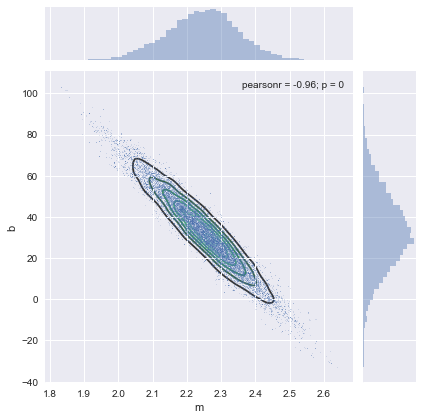

In [10]:
joint_kde_scatter = (sns.jointplot(x='m', y='b', data=parameter_samples, 
                                   kind='scatter',marker='.',s=0.1).
                     plot_joint(sns.kdeplot, zorder=0, n_levels=6))

Finally, I'll do a "pairplot".  This shows the relationships between each pair of parameters.  This is particularly useful when your model includes more than 2 parameters, since in that case you can't just plot the joint distribution of all the parameters.

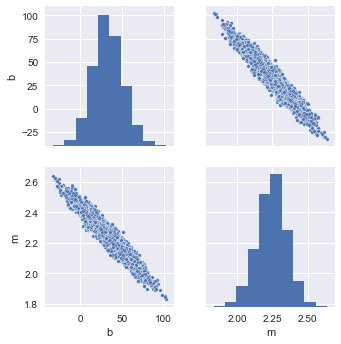

In [11]:
sns.pairplot(parameter_samples, markers='.')

The plots on the diagonal give the marginal distributions, and the ones on the off-diagonal the joint distributions of each pair of variables.

## Step 6: report results
The plots above summarize your results, but if you want to report a single number and uncertainties on each parameter, you  can calculate the MAP (maximum _a posteriori_) value and the values of the 16th and 84th percentile of the marginal distributions on each parameter.  These percentiles correspond to $\pm 1.0 \sigma$ for a Gaussian distribution.

In [12]:
# calculating the MAP and values can be done concisely using pandas
q = parameter_samples.quantile([0.16,0.50,0.84], axis=0)

In [13]:
q

,b,m
0.16,15.618475,2.140827
0.50,32.743791,2.249190
0.84,51.277709,2.347182


So we would report our results as follows:

In [14]:
print("m = {:.2f} + {:.2f} - {:.2f}".format(q['m'][0.50], 
                                            q['m'][0.84]-q['m'][0.50],
                                            q['m'][0.50]-q['m'][0.16]))
print("b = {:.1f} + {:.1f} - {:.1f}".format(q['b'][0.50], 
                                            q['b'][0.84]-q['b'][0.50],
                                            q['b'][0.50]-q['b'][0.16]))

m = 2.25 + 0.10 - 0.11
b = 32.7 + 18.5 - 17.1


Compare to the least squares results (see Figure 1 of HBL):
$$ m = 2.24 \pm 0.11 $$
$$ b = 34 \pm 18 $$